In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random
import matplotlib.pyplot as plt
%matplotlib inline

# **Exercice 1**

## **Compréhension du cours**
1. Quelle est la différence fondamentale entre l'apprentissage par renforcement et
l'apprentissage supervisé ou non supervisé ?
2. Quels sont les composants essentiels de l'apprentissage par renforcement ?
3. Quels sont les deux types de politiques en apprentissage par renforcement ? Quelle est la
sortie associée à chaque politique en fonction de l'état d'entrée ?
4. Quel est l'impact du facteur gamma dans le calcul du retour (return) ?
5. Quel est le principe des méthodes de gradient de politique ? Expliquez les grandes étapes de
l'algorithme REINFORCE.

### 1.
L'apprentissage par renforcement repose sur des interactions avec un environnement : l'agent apprend par essais/erreurs en recevant des **récompenses**. En apprentissage supervisé, on apprend à partir de données **étiquetées** ; en non supervisé, il n’y a **aucune étiquette**, et on cherche à découvrir des structures cachées dans les données.

### 2.
- **Agent** : prend des décisions.  
- **Environnement** : avec lequel l’agent interagit.  
- **État (state)** : situation actuelle de l’environnement.  
- **Action** : choix effectué par l’agent.  
- **Politique (policy)** : stratégie de sélection des actions.  
- **Récompense (reward)** : feedback reçu.  
- **Fonction de valeur** : estime des récompenses futures.  
- **Modèle (optionnel)** : prédit la dynamique de l’environnement.

### 3.
- **Politique déterministe** : donne **une action précise** pour un état donné.  
  → Sortie : une action.  
- **Politique stochastique** : donne une **distribution de probabilité** sur les actions.  
  → Sortie : distribution d’actions (ex. softmax).

### 4.
Le facteur gamma (0 ≤ γ ≤ 1) **pondère l’importance des récompenses futures** :  
- γ proche de 0 → l’agent privilégie les **récompenses immédiates**.  
- γ proche de 1 → l’agent valorise les **récompenses futures**, favorisant une vision long terme.

### 5.
Les méthodes de gradient de politique optimisent directement la **politique paramétrée** (πθ) en suivant le **gradient de l'espérance du retour**.

**Algorithme REINFORCE :**  
1. Générer un épisode en suivant la politique πθ.  
2. Calculer le retour Gt pour chaque pas de temps t.  
3. Mettre à jour les paramètres θ avec :  
   **θ ← θ + α * Gt * ∇θ log πθ(at|st)**  
4. Répéter.



## **QCM : Concepts clés du Reinforcement Learning**
**Question 1 : L’état (state)**

**Dans le contexte du RL, quel énoncé est faux concernant l’état (state) ?**

A) L’état $s_{t}$​ représente toutes les informations nécessaires pour déterminer les récompenses futures.

B) Deux états différents peuvent mener à la même action optimale.

C) L’état peut être défini par des caractéristiques partielles de l’environnement sans impacter la politique optimale.

D) Si un agent suit une politique optimale, il connaîtra nécessairement la séquence exacte des états futurs.


**Question 2 : La politique (policy)**

**Quelle affirmation est correcte concernant la politique $\pi$ d’un agent ?**

A) Une politique stochastique assigne une probabilité aux actions, tandis qu’une politique déterministe choisit toujours la même action pour un état donné.

B) Toute politique déterministe est nécessairement meilleure qu’une politique stochastique.

C) La politique optimale est toujours unique pour un problème donné.

**Question 3 : La Value Function**

Quelle est la bonne définition de la value function $V_{\pi}(s)$?

A) C’est la somme des récompenses obtenues par l’agent en suivant la politique $\pi$ à partir de l’état s.

B) C’est l’espérance du return $G_{t}$​, conditionnée par le fait que l’agent commence à s et suit la politique $\pi$.

C) Elle est définie uniquement pour les politiques optimales et ne peut pas être calculée pour une politique aléatoire.

**Question 4 : La Q-function**

Pourquoi la Q-function $Q_{\pi}(s,a)$ est-elle plus informative que la value function $V_{\pi}(s)$?

A) Elle prend en compte à la fois l’état actuel et l’action choisie, contrairement à $V_{\pi}(s)$.

B) Elle est toujours plus précise et plus rapide à calculer que $V_{\pi}(s)$.

C) Elle ne dépend pas de la politique $\pi$ et peut être utilisée dans n'importe quel contexte.

D) Elle ne peut être utilisée que pour des politiques déterministes.

### **Question 1 : L’état (state)**  
**Énoncé faux :**  
✅ **D) Si un agent suit une politique optimale, il connaîtra nécessairement la séquence exacte des états futurs.**  
> Faux, car l’environnement peut être stochastique, donc même en suivant une politique optimale, la trajectoire des états reste incertaine.


### **Question 2 : La politique (policy)**  
**Énoncé correct :**  
✅ **A) Une politique stochastique assigne une probabilité aux actions, tandis qu’une politique déterministe choisit toujours la même action pour un état donné.**  
> Vrai, c’est la définition exacte des deux types de politiques.


### **Question 3 : La Value Function**  
**Bonne définition :**  
✅ **B) C’est l’espérance du return $G_{t}$, conditionnée par le fait que l’agent commence à s et suit la politique $\pi$.**  
> Vrai, c’est la définition mathématique de $V_{\pi}(s)$.


### **Question 4 : La Q-function**  
**Raison correcte pour sa richesse d'information :**  
✅ **A) Elle prend en compte à la fois l’état actuel et l’action choisie, contrairement à $V_{\pi}(s)$.**  
> Vrai, la Q-function précise la valeur d’une **action spécifique** dans un **état donné**, ce qui est plus informatif que la value function seule.



## **Exemple d'application : Gestion du niveau d'eau dans un réservoir de refroidissement**

### **Description**
Dans un processus de fabrication de semi-conducteurs, l'étape de refroidissement des équipements nécessite un système de gestion du niveau d'eau dans un réservoir de refroidissement. L'eau est utilisée pour maintenir une température stable dans les équipements sensibles.

Le réservoir de refroidissement doit être maintenu à un niveau optimal pour garantir une efficacité maximale. Si le niveau d'eau est trop bas, cela peut entraîner une panne de la pompe de refroidissement, risquant une surchauffe des équipements. Si le niveau est trop élevé, l'eau peut déborder ou provoquer des pertes d'efficacité.

### **Objectif de l'Exercice**
L'agent doit réguler le niveau d'eau du réservoir en choisissant entre deux actions : ajouter ou retirer de l'eau. Son objectif est de maintenir ce niveau dans une plage acceptable. Les quantités d'eau modifiées à chaque action sont déterminées aléatoirement selon une distribution uniforme dans l'intervalle [0, 0.5].

### **Valeurs possibles pour le niveau d'eau**
- **Plage de variation** : Le niveau d'eau peut aller de **0 à 12 litres**.  
- **Plage optimale** : Il est préférable qu'il reste entre **4 et 8 litres**.  
- **Limite stricte** : Un niveau supérieur à **12 litres** est interdit en raison de la capacité maximale du réservoir.

### **Questions**
1.   Quelle est la représentation de l’état ($s_{t}$) de l'agent dans cet exercice ?
2.   Quelles sont les actions ($a_{t}$) possibles pour l’agent ? Quel est le type de variables aléatoires pour modéliser ce type d'espace d'actions ?
3.   Comment définir une fonction de récompense ($R_{t}$) qui encourage l’agent à maintenir le niveau d’eau dans la plage optimale ?
4.   Sur la base des questions 1, 2 et 3 et des exemples du code présentés dans le cours, implémenter l’agent en utilisant l’algorithme REINFORCE pour l’entrainement.

### 1. **Représentation de l'état (s_t)**

L'état représente le niveau d'eau dans le réservoir à un instant t. Dans ce cas, c'est une valeur continue comprise entre 0 et 12 litres. Donc:

s_t = niveau d'eau actuel (en litres)

### 2. **Actions possibles (a_t)**

Les actions possibles pour l'agent sont:
- Ajouter de l'eau (a_t = 1)
- Retirer de l'eau (a_t = 0)

Le type de variable aléatoire pour modéliser cet espace d'actions est une variable aléatoire de Bernoulli, car nous avons deux actions possibles et discrètes. Cependant, l'effet de chaque action est modulé par une quantité aléatoire d'eau (entre 0 et 0.5 litres) suivant une distribution uniforme.

### 3. **Fonction de récompense (R_t)**

La fonction de récompense doit encourager l'agent à maintenir le niveau d'eau dans la plage optimale (4-8 litres). Je propose la fonction de récompense suivante:

- Si le niveau d'eau est entre 4 et 8 litres (plage optimale): R_t = +1 (récompense positive)
- Si le niveau d'eau est entre 0 et 4 litres ou entre 8 et 12 litres (acceptable mais non optimal): R_t = -0.5 (pénalité légère)
- Si le niveau d'eau est inférieur à 0 ou supérieur à 12 litres (hors limites): R_t = -10 (forte pénalité)

Cette fonction de récompense incite l'agent à maintenir le niveau d'eau dans la plage optimale.

### 4. **Implémentation avec l'algorithme REINFORCE**


##### Explication de l'implémentation

#### Structure de l'agent REINFORCE

1. **Modèle de politique (PolicyNetwork)**:
   - Réseau neuronal qui prend l'état (niveau d'eau) en entrée et produit une probabilité pour choisir l'action "ajouter de l'eau"
   - Utilise la fonction sigmoïde à la sortie pour obtenir une probabilité entre 0 et 1

2. **Environnement (WaterReservoirEnv)**:
   - Gère l'état du réservoir d'eau
   - Implémente la dynamique du système avec les modifications aléatoires de niveau d'eau
   - Calcule les récompenses selon la fonction définie

3. **Agent REINFORCE**:
   - Utilise une politique stochastique pour choisir les actions
   - Stocke les log-probabilités et les récompenses pour chaque action
   - Met à jour sa politique après chaque épisode complet en utilisant les rendements cumulés (returns)

#### Algorithme d'apprentissage

1. L'agent observe l'état (niveau d'eau)
2. Il choisit une action (ajouter ou retirer de l'eau) selon sa politique
3. L'environnement exécute l'action, ce qui modifie le niveau d'eau
4. L'agent reçoit une récompense selon le nouveau niveau d'eau
5. Ces étapes sont répétées jusqu'à la fin de l'épisode
6. À la fin de l'épisode, l'agent met à jour sa politique en maximisant les récompenses attendues

L'agent apprend progressivement à maintenir le niveau d'eau dans la plage optimale (4-8 litres) en équilibrant les actions d'ajout et de retrait d'eau.

Cette implémentation comprend également des fonctions pour visualiser les performances de l'agent pendant l'entraînement et pour tester l'agent entraîné sur plusieurs épisodes.

Épisode 100	Récompense moyenne: -4.97
Épisode 200	Récompense moyenne: 6.51
Épisode 300	Récompense moyenne: 4.47
Épisode 400	Récompense moyenne: 15.43
Épisode 500	Récompense moyenne: 29.88
Épisode 600	Récompense moyenne: -3.02
Épisode 700	Récompense moyenne: -6.66
Épisode 800	Récompense moyenne: 10.11
Épisode 900	Récompense moyenne: 43.26
Épisode 1000	Récompense moyenne: 49.42


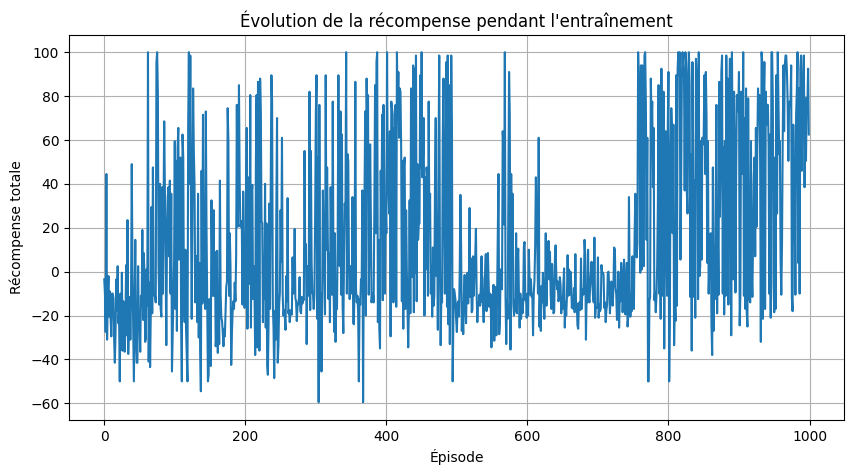

Épisode 1, niveau d'eau initial: 6.64
  Étape 1: Action: Retirer de l'eau, Niveau d'eau: 6.45, Récompense: 1.00
  Étape 2: Action: Retirer de l'eau, Niveau d'eau: 6.18, Récompense: 1.00
  Étape 3: Action: Retirer de l'eau, Niveau d'eau: 6.11, Récompense: 1.00
  Étape 4: Action: Ajouter de l'eau, Niveau d'eau: 6.34, Récompense: 1.00
  Étape 5: Action: Retirer de l'eau, Niveau d'eau: 6.31, Récompense: 1.00
  Étape 6: Action: Ajouter de l'eau, Niveau d'eau: 6.77, Récompense: 1.00
  Étape 7: Action: Retirer de l'eau, Niveau d'eau: 6.45, Récompense: 1.00
  Étape 8: Action: Retirer de l'eau, Niveau d'eau: 6.09, Récompense: 1.00
  Étape 9: Action: Retirer de l'eau, Niveau d'eau: 5.97, Récompense: 1.00
  Étape 10: Action: Ajouter de l'eau, Niveau d'eau: 6.02, Récompense: 1.00
  Étape 11: Action: Retirer de l'eau, Niveau d'eau: 5.86, Récompense: 1.00
  Étape 12: Action: Retirer de l'eau, Niveau d'eau: 5.61, Récompense: 1.00
  Étape 13: Action: Retirer de l'eau, Niveau d'eau: 5.17, Récompense: 1

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque

# Définition des paramètres du problème
MIN_WATER_LEVEL = 0
MAX_WATER_LEVEL = 12
OPTIMAL_MIN = 4
OPTIMAL_MAX = 8
WATER_CHANGE_RANGE = 0.5

# Définition du modèle de politique (Policy Network)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sortie entre 0 et 1 pour la probabilité d'action
        return x

# Environnement du réservoir d'eau
class WaterReservoirEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        # Initialisation du niveau d'eau aléatoirement
        self.water_level = np.random.uniform(0, 12)
        return np.array([self.water_level])

    def step(self, action):
        # Déterminer la quantité d'eau à ajouter ou retirer (aléatoire entre 0 et 0.5)
        water_change = np.random.uniform(0, WATER_CHANGE_RANGE)

        # Appliquer l'action (0: retirer de l'eau, 1: ajouter de l'eau)
        if action == 1:  # Ajouter de l'eau
            self.water_level += water_change
        else:  # Retirer de l'eau
            self.water_level -= water_change

        # Calcul de la récompense
        if OPTIMAL_MIN <= self.water_level <= OPTIMAL_MAX:
            reward = 1.0  # Niveau optimal
        elif MIN_WATER_LEVEL <= self.water_level < OPTIMAL_MIN or OPTIMAL_MAX < self.water_level <= MAX_WATER_LEVEL:
            reward = -0.5  # Non optimal mais acceptable
        else:
            reward = -10.0  # Hors limites

        # Vérifier si l'épisode est terminé (eau hors limites)
        done = self.water_level < MIN_WATER_LEVEL or self.water_level > MAX_WATER_LEVEL

        return np.array([self.water_level]), reward, done

# Agent REINFORCE
class REINFORCEAgent:
    def __init__(self, input_dim, output_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.policy = PolicyNetwork(input_dim, output_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.saved_log_probs = []
        self.rewards = []

    def select_action(self, state):
        state = torch.FloatTensor(state)
        probs = self.policy(state)
        action_dist = torch.distributions.Bernoulli(probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        self.saved_log_probs.append(log_prob)
        return action.item()

    def finish_episode(self):
        R = 0
        policy_loss = []
        returns = deque()

        # Calculer les rendements (returns) pour chaque pas de temps
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.appendleft(R)

        returns = torch.tensor(list(returns))

        # Normaliser les rendements (améliore la stabilité)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Calculer la perte de politique (policy loss)
        for log_prob, R in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        # Mettre à jour la politique
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        # Réinitialiser les listes
        self.saved_log_probs = []
        self.rewards = []

# Fonction d'entraînement
def train_agent(num_episodes=1000, max_steps=100):
    env = WaterReservoirEnv()
    agent = REINFORCEAgent(input_dim=1, output_dim=1)

    episode_rewards = []

    for i_episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for t in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)

            agent.rewards.append(reward)
            episode_reward += reward

            state = next_state

            if done:
                break

        agent.finish_episode()
        episode_rewards.append(episode_reward)

        if (i_episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Épisode {i_episode+1}\tRécompense moyenne: {avg_reward:.2f}")

    return agent, episode_rewards

# Fonction pour visualiser les performances de l'agent
def plot_performance(episode_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.xlabel('Épisode')
    plt.ylabel('Récompense totale')
    plt.title('Évolution de la récompense pendant l\'entraînement')
    plt.grid(True)
    plt.show()

# Fonction pour tester l'agent après l'entraînement
def test_agent(agent, num_episodes=10, max_steps=100):
    env = WaterReservoirEnv()

    for i_episode in range(num_episodes):
        state = env.reset()
        print(f"Épisode {i_episode+1}, niveau d'eau initial: {state[0]:.2f}")

        for t in range(max_steps):
            action = agent.select_action(state)
            action_name = "Ajouter de l'eau" if action == 1 else "Retirer de l'eau"
            next_state, reward, done = env.step(action)

            print(f"  Étape {t+1}: Action: {action_name}, Niveau d'eau: {next_state[0]:.2f}, Récompense: {reward:.2f}")

            state = next_state

            if done:
                print(f"  Épisode terminé après {t+1} étapes")
                break

        print("")

# Si vous souhaitez exécuter l'entraînement et tester l'agent
if __name__ == "__main__":
    # Entraînement
    agent, episode_rewards = train_agent(num_episodes=1000, max_steps=100)

    # Visualisation des performances
    plot_performance(episode_rewards)

    # Test de l'agent entraîné
    test_agent(agent, num_episodes=5, max_steps=100)